# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020-23 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [2]:
import uproot
import numpy as np 
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Input data
This opens input data files and assigns them to variables.

In [3]:
path = '' # set this to '' to run on the GitHub version
events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [49]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
isMuon = []
BinvMass = []
DinvMass = []
RinvMass = []
MuinvMass = []
probPi = []
probK = []
test = []
H21invMass = []
H31invMass = []
# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events. 
# It is recommended to keep the number of events limited while developing the analysis.
MAX_EVENTS = 10000000

# Select which set of input data is to be analysed. Uncomment exactly one line
#trees = [events_sim['PhaseSpaceTree']]                       # Simulation
#trees = [events_down['DecayTree']]                          # Magnet down data
#trees = [events_up['DecayTree']]                             # Magnet up data
trees = [events_down['DecayTree'],events_up['DecayTree']]   # Magnet down+up data

# This loop goes over the trees to be analysed
for tree in trees:
    # This outer loop is a technical loop of uproot over chunks of events
#    for data in tree.iterate(['H*_P[XYZ]','H*_Charge','H*_Prob*','H*_isMuon'], library='np'): #not working ...
    for data in tree.iterate( library='np' ):
        # As Python can handle calculations with arrays, we can calculate derived quantities here
        pT_H1 = np.sqrt(data['H1_PX']**2+data['H1_PY']**2)
        pT_H2 = np.sqrt(data['H2_PX']**2+data['H2_PY']**2)
        pT_H3 = np.sqrt(data['H3_PX']**2+data['H3_PY']**2)

        # Your invariant mass calculation should go here
        muon_mass = 10000
        pion_mass = 139.57039
        kaon_mass = 493.67
        H1_pTot = np.sqrt(data['H1_PX']**2+data['H1_PY']**2+data['H1_PZ']**2)
        H2_pTot = np.sqrt(data['H2_PX']**2+data['H2_PY']**2+data['H2_PZ']**2)
        H3_pTot = np.sqrt(data['H3_PX']**2+data['H3_PY']**2+data['H3_PZ']**2)
        
        H_pXTot = data['H1_PX'] + data['H2_PX'] + data['H3_PX']
        H_pYTot = data['H1_PY'] + data['H2_PY'] + data['H3_PY']
        H_pZTot = data['H1_PZ'] + data['H2_PZ'] + data['H3_PZ']
        
        D_PXTot1 = data['H1_PX'] + data['H2_PX']
        D_PYTot1 = data['H1_PY'] + data['H2_PY']
        D_PZTot1 = data['H1_PZ'] + data['H2_PZ']
        
        D_PXTot2 = data['H1_PX'] + data['H3_PX']
        D_PYTot2 = data['H1_PY'] + data['H3_PY']
        D_PZTot2 = data['H1_PZ'] + data['H3_PZ']
        
        R_PXTot1 = data['H1_PX'] + data['H3_PX']
        R_PYTot1 = data['H1_PY'] + data['H3_PY']
        R_PZTot1 = data['H1_PZ'] + data['H3_PZ']
        
        R_PXTot2 = data['H1_PX'] + data['H2_PX']
        R_PYTot2 = data['H1_PY'] + data['H2_PY']
        R_PZTot2 = data['H1_PZ'] + data['H2_PZ']
        # This loop will go over individual events
        for i in range(0,len(data['H1_PZ'])):
            event_counter += 1
            H_piprob_acc = 0.55
            H_Kprob_acc = 0.60
            H_23piprobmin = 0.25
            H_23Kprobmin = 0.25
            
            errormargin = 0
            if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
            if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
            # Decide here which events to analyse
            if (data['H1_PZ'][i] < 0) or (data['H2_PZ'][i] < 0) or (data['H3_PZ'][i] < 0): continue

            if (data['H1_isMuon'][i] == 1) or (data['H2_isMuon'][i] == 1) or (data['H3_isMuon'][i] == 1): continue
            if (data['H1_ProbPi'][i] < H_piprob_acc):continue
            
            if (data['H2_ProbPi'][i] > H_23piprobmin) and (data['H3_ProbPi'][i] > H_23piprobmin):continue
            if (data['H2_ProbK'][i] > H_23Kprobmin) and (data['H3_ProbK'][i] > H_23Kprobmin):continue
            
            if not ( (data['H2_ProbPi'][i] > H_piprob_acc) or (data['H2_ProbK'][i] > H_Kprob_acc)):continue
            if not ( (data['H3_ProbPi'][i] > H_piprob_acc) or (data['H3_ProbK'][i] > H_Kprob_acc)):continue
            H1_ET = np.sqrt((pion_mass**2) + (H1_pTot[i])**2)
 
            if (data['H2_ProbK'][i] > data['H2_ProbPi'][i]) and (data['H3_ProbK'][i] < data['H3_ProbPi'][i]):
                H2_ET = np.sqrt((kaon_mass**2) + (H2_pTot[i])**2)
                H3_ET = np.sqrt((pion_mass**2) + (H3_pTot[i])**2)
                B_invMass = np.sqrt(((H1_ET + H2_ET + H3_ET) ** 2) - (H_pXTot[i])**2 - (H_pYTot[i])**2 - (H_pZTot[i])**2)
                if (B_invMass < 5220 or B_invMass > 5350):continue
                D_invMass = ((H1_ET + H2_ET) ** 2) - (D_PXTot1[i])**2 - (D_PYTot1[i])**2 - (D_PZTot1[i])**2
                R_invMass = ((H1_ET + H3_ET) ** 2) - (R_PXTot1[i])**2 - (R_PYTot1[i])**2 - (R_PZTot1[i])**2
                H_21invMass = ((H1_ET + H2_ET) ** 2) - (D_PXTot1[i])**2 - (D_PYTot1[i])**2 - (D_PZTot1[i])**2
                H_31invMass = ((H1_ET + H3_ET) ** 2) - (R_PXTot1[i])**2 - (R_PYTot1[i])**2 - (R_PZTot1[i])**2
                #if not (H_21invMass < 1728**2 or H_21invMass > 2000**2):continue
                #if not (H_31invMass < 1728**2 or H_31invMass > 2000**2):continue
                #if not (R_invMass < 3021 or R_invMass > 3071):continue
            elif (data['H2_ProbK'][i] < data['H2_ProbPi'][i]) and (data['H3_ProbK'][i] > data['H3_ProbPi'][i]):            
                H2_ET = np.sqrt((pion_mass**2) + (H2_pTot[i])**2)
                H3_ET = np.sqrt((kaon_mass**2) + (H3_pTot[i])**2)
                B_invMass = np.sqrt(((H1_ET + H2_ET + H3_ET) ** 2) - (H_pXTot[i])**2 - (H_pYTot[i])**2 - (H_pZTot[i])**2)
                if (B_invMass < 5220 or B_invMass > 5350):continue
                D_invMass = ((H1_ET + H3_ET) ** 2) - (D_PXTot2[i])**2 - (D_PYTot2[i])**2 - (D_PZTot2[i])**2
                R_invMass = ((H1_ET + H2_ET) ** 2) - (R_PXTot2[i])**2 - (R_PYTot2[i])**2 - (R_PZTot2[i])**2
                H_21invMass = ((H1_ET + H2_ET) ** 2) - (D_PXTot1[i])**2 - (D_PYTot1[i])**2 - (D_PZTot1[i])**2
                H_31invMass = ((H1_ET + H3_ET) ** 2) - (R_PXTot1[i])**2 - (R_PYTot1[i])**2 - (R_PZTot1[i])**2
                #if not (H_21invMass < 1728**2 or H_21invMass > 2000**2):continue
                #if not (H_31invMass < 1728**2 or H_31invMass > 2000**2):continue
                #if not (R_invMass < 3021 or R_invMass > 3071):continue
            else: continue
    
            # Fill arrays of events to be plotted and analysed further below
            # Adding values for all three hadrons to the same variable here
            pT.append(pT_H1[i])
            pT.append(pT_H2[i])
            pT.append(pT_H3[i])
            pX.append(data['H1_PX'][i])
            pX.append(data['H2_PX'][i])
            pX.append(data['H3_PX'][i])
            pY.append(data['H1_PY'][i])
            pY.append(data['H2_PY'][i])
            pY.append(data['H3_PY'][i])
            pZ.append(data['H1_PZ'][i])
            pZ.append(data['H2_PZ'][i])
            pZ.append(data['H3_PZ'][i])
            BinvMass.append(B_invMass)
            DinvMass.append(D_invMass)
            RinvMass.append(R_invMass)
            H21invMass.append(H_21invMass)
            H31invMass.append(H_31invMass)
            #MuinvMass.append(Mu_invMass)
            isMuon.append(data['H1_isMuon'][i])
            probPi.append(data['H2_ProbPi'][i])
            probK.append(data['H2_ProbK'][i])
            probk = np.array(probK)
            probpi = np.array(probPi)
            
print('Read {:d} events'.format(event_counter))
print(len(isMuon))

Input data variables:
['B_FlightDistance', 'B_VertexChi2', 'H1_PX', 'H1_PY', 'H1_PZ', 'H1_ProbK', 'H1_ProbPi', 'H1_Charge', 'H1_IPChi2', 'H1_isMuon', 'H2_PX', 'H2_PY', 'H2_PZ', 'H2_ProbK', 'H2_ProbPi', 'H2_Charge', 'H2_IPChi2', 'H2_isMuon', 'H3_PX', 'H3_PY', 'H3_PZ', 'H3_ProbK', 'H3_ProbPi', 'H3_Charge', 'H3_IPChi2', 'H3_isMuon']
Read 100000 events
Read 200000 events
Read 300000 events
Read 400000 events
Read 500000 events
Read 600000 events
Read 700000 events
Read 800000 events
Read 900000 events
Read 1000000 events
Read 1100000 events
Read 1200000 events
Read 1300000 events
Read 1400000 events
Read 1500000 events
Read 1600000 events
Read 1700000 events
Read 1800000 events
Read 1900000 events
Read 2000000 events
Read 2100000 events
Read 2200000 events
Read 2300000 events
Read 2400000 events
Read 2500000 events
Read 2600000 events
Read 2700000 events
Read 2800000 events
Read 2900000 events
Read 3000000 events
Read 3100000 events
Read 3200000 events
Read 3300000 events
Read 3400000 even

### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram
Plotting 2D histogram


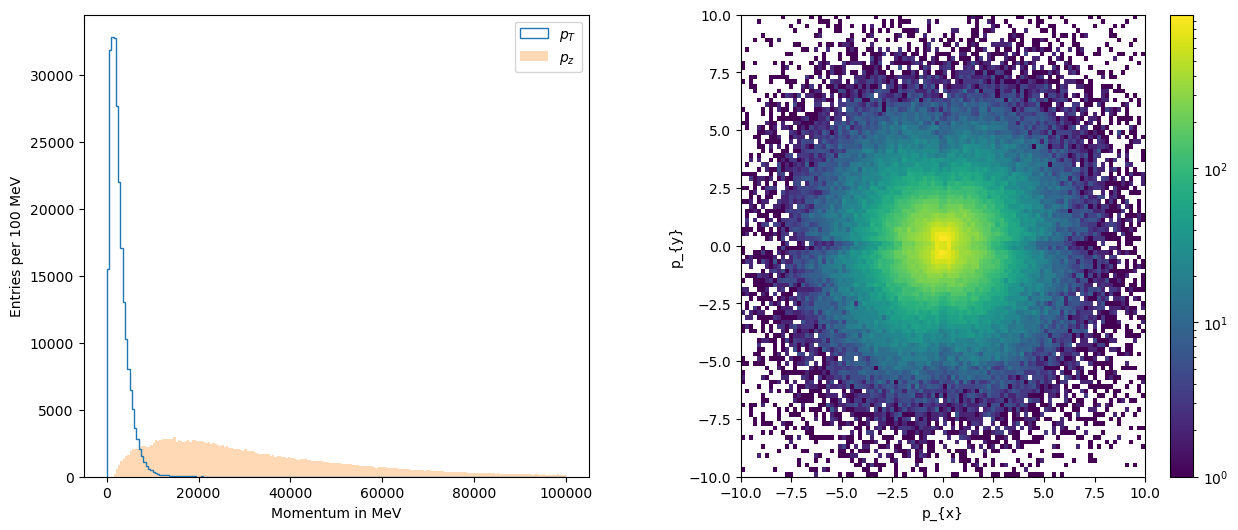

In [50]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('p_{x}')
ax[1].set_ylabel('p_{y}')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

Plotting 1D histogram
Plotting 1D histogram
Plotting 1D histogram
Plotting 2D histogram


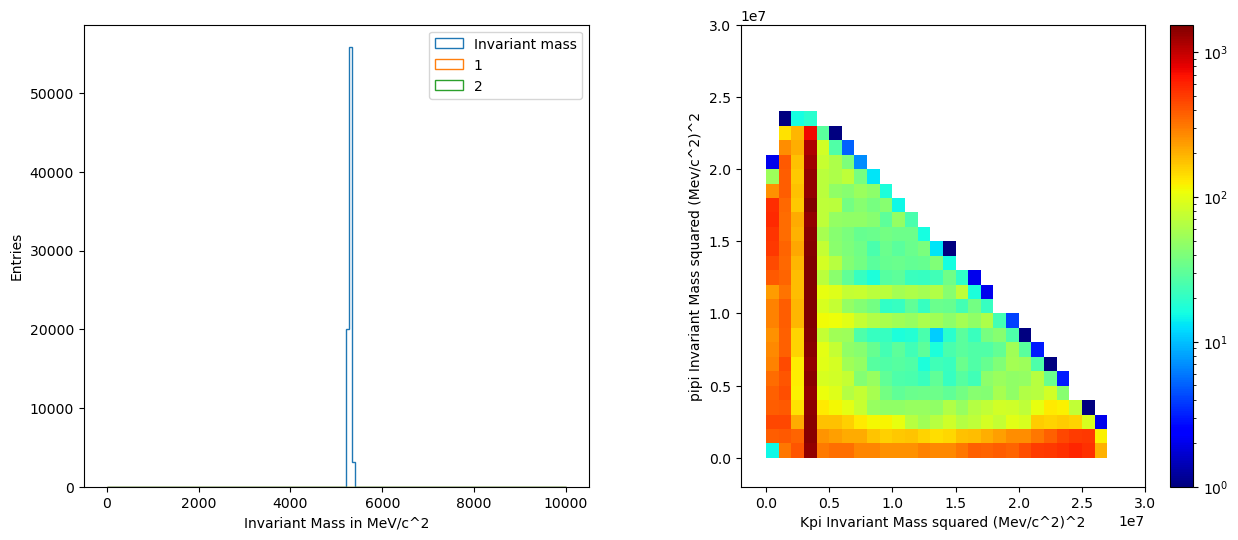

In [52]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are# set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(BinvMass, bins = 150, range = [0, 10000],histtype='step', label = 'Invariant mass')
ax[0].set_xlabel('Invariant Mass in MeV/c^2')
ax[0].set_ylabel('Entries/3MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(DinvMass, bins = 150, range = [0,10000],histtype='step', label = '1')
ax[0].set_xlabel('Invariant Mass in MeV/c^2')
ax[0].set_ylabel('Entries')
ax[0].legend()
plt.savefig('pTpZ.pdf')

print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(RinvMass, bins = 150, range = [0, 10000],histtype='step', label = '2')
ax[0].set_xlabel('Invariant Mass in MeV/c^2')
ax[0].set_ylabel('Entries')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(DinvMass, RinvMass, bins = [32,32], range = [[-2000000,30000000],[-2000000,30000000]],cmap='jet', norm=colors.LogNorm())
ax[1].set_xlabel('Kpi Invariant Mass squared (Mev/c^2)^2')
ax[1].set_ylabel('pipi Invariant Mass squared (Mev/c^2)^2')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('Simulated_pXpY.pdf')

### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

Fit results with chi2/ndf 0.0 / 75
Par 1: -0.000000 +/- 0.000000
Par 2: 0.000000 +/- 0.000000
Par 3: 9999.994637 +/- 0.000993


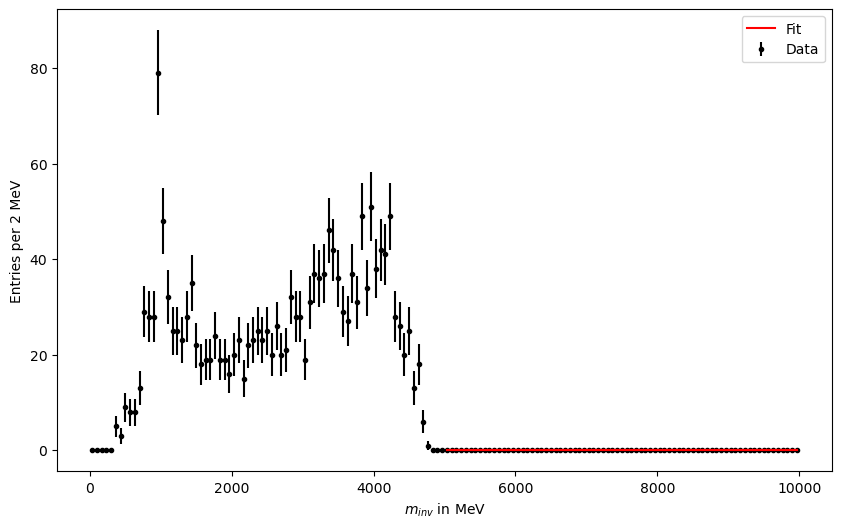

In [85]:
# decaying exponential function
def exponential(x, norm, decay):
    xoffset = 0 # this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array( norm * np.exp(-(x-xoffset)/decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# fit function combining two individual functions
def fit_function(x, norm, normE, decay):
    return np.array( constant(x, norm) + exponential(x, normE, decay) )

def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays

    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values as given in p0
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0) # fit
    
    # evaluate chi2
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
    
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2])
    a.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

    # plot decoration
    a.legend()
    a.set_xlabel('$m_{inv}$ in MeV')
    a.set_ylabel('Entries per 2 MeV')
    plt.savefig(fname)

coeff_pT,cov_pT, bin_centres_pT, bin_centres_red_pT, chi2_pT, ndf_pT = fit_data( bins_pT, values_pT, 5000, 15000, [100,10000,10000] )

print_results(coeff_pT,cov_pT, chi2_pT, ndf_pT)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plot_results(ax,bin_centres_pT,bin_centres_red_pT,values_pT,coeff_pT,'fit_pT.pdf')

### Manipulation of 2D histograms

The following is an example code to demonstrate manipulation of the content of 2D histograms. It first produces two dummy histograms before working out the bin centres, subtracting the histogram contents, and finally plotting. The subtraction bit can of course be replaced by more complex operations as well.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

### ignore this bit and replace by however you produce your two 2D histograms to be subtracted ###
xvalues = []
yvalues = []
weights1 = []
weights2 = []
for x in range(100):
    for y in range(100):
        xvalues.append(-10+x/5.+0.1) # bin centre for x
        yvalues.append(-10+y/5.+0.1) # bin centre for y
        weights1.append((x-y))       # weights for histo1, this would be filled automatically
        weights2.append((x-y)+50)    # weights for histo2
h2d1 = ax[0].hist2d(xvalues,yvalues,weights=weights1,bins = [100,100], range = [[-10,10],[-10,10]])        
h2d2 = ax[1].hist2d(xvalues,yvalues,weights=weights2,bins = [100,100], range = [[-10,10],[-10,10]])
### end ignoring here :) ###

# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
h2d3 = ax[2].hist2d(xcentres,ycentres,weights=wsub, bins = [h2d1[1],h2d1[2]]) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0]) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1]) # let's add the colour scale for histo 2
fig.colorbar(h2d3[3],ax=ax[2]) # let's add the colour scale for histo 3